In [41]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt

## Loading data

In [45]:
df = pd.read_csv("dataset/start_deep/posneg.txt", sep=" ", names=["filename", "class"])
df = df.astype(str)
df.head()

,filename,class
0,1/Image000605.pgm,1
1,1/Image000607.pgm,1
2,1/Image000608.pgm,1
3,1/Image000609.pgm,1
4,1/Image000610.pgm,1


In [46]:
df_test = pd.read_csv("dataset/start_deep/testposneg.txt", sep=" ", names=["filename", "class"])
df_test = df_test.astype(str)
df_test.head()

,filename,class
0,"test_images/googlefaces_test/503_1__t0,0_r0_s1...",1
1,"test_images/googlefaces_test/367_0__t0,0_r0_s1...",1
2,"test_images/googlefaces_test/10_0__t0,0_r0_s1.pgm",1
3,"test_images/googlefaces_test/53_0__t0,0_r0_s1.pgm",1
4,"test_images/googlefaces_test/323_0__t0,0_r0_s1...",1


In [50]:
## Changing files from pgm to jpg
# from PIL import Image
# for file in df_test["filename"]:
#     abs_path = "C:/Users/joanc/PycharmProjects/projet_ml/dataset/start_deep/" + file
#     img = Image.open(abs_path)
#     new_name = abs_path.replace(".pgm", ".jpg")
#     if new_name != abs_path:
#         img.save(new_name)

In [51]:
# from PIL import Image
# for file in df["filename"]:
#     abs_path = "C:/Users/joanc/PycharmProjects/projet_ml/dataset/start_deep/train_images/" + file
#     img = Image.open("C:/Users/joanc/PycharmProjects/projet_ml/dataset/start_deep/train_images/" + file)
#     new_name = abs_path.replace(".pgm", ".jpg")
#     img.save(new_name)

In [52]:
# ranming .pgm to jpg
def replace_name(name):
    return name.replace(".pgm", ".jpg")
df["filename"] = df["filename"].apply(replace_name)
df_test["filename"] = df_test["filename"].apply(replace_name)

In [53]:
df.head()

,filename,class
0,1/Image000605.jpg,1
1,1/Image000607.jpg,1
2,1/Image000608.jpg,1
3,1/Image000609.jpg,1
4,1/Image000610.jpg,1


### Split train and validation

In [54]:
from sklearn.model_selection import train_test_split

df_train, df_val = train_test_split(df)

In [55]:
root_dir = "C:/Users/joanc/PycharmProjects/projet_ml/dataset/start_deep/train_images/"

In [76]:
from PIL import Image
img = Image.open(root_dir+df["filename"][0])
IMG_HEIGHT, IMG_WIDTH = img.height, img.width
IMG_HEIGHT, IMG_WIDTH

(36, 36)

### Creating generators

In [57]:
batch_size=32
train_image_generator = ImageDataGenerator(rescale=1./255)
train_data_gen = train_image_generator.flow_from_dataframe(df_train, 
                                                           directory=root_dir,
                                                          color_mode="grayscale", x_col="filename", y_col="class",
                                                          target_size=(IMG_HEIGHT, IMG_WIDTH), batch_size=batch_size,
                                                          class_mode="binary",
                                                          shuffle=True)

Found 68790 images belonging to 2 classes.


In [58]:
batch_size=32
val_image_generator = ImageDataGenerator(rescale=1./255)
val_data_gen = val_image_generator.flow_from_dataframe(df_val, 
                                                           directory=root_dir,
                                                          color_mode="grayscale", x_col="filename", y_col="class",
                                                          target_size=(IMG_HEIGHT, IMG_WIDTH), batch_size=batch_size,
                                                          class_mode="binary",
                                                          shuffle=True)

Found 22930 images belonging to 2 classes.


In [59]:
test_generator = ImageDataGenerator(rescale=1./255)
test_data_gen = test_generator.flow_from_dataframe(df_test, 
                                                           directory="C:/Users/joanc/PycharmProjects/projet_ml/dataset/start_deep/",
                                                          color_mode="grayscale", x_col="filename", y_col="class",
                                                          target_size=(IMG_HEIGHT, IMG_WIDTH), batch_size=batch_size,
                                                          class_mode="binary",
                                                          shuffle=True)

Found 7628 images belonging to 2 classes.


In [60]:
sample_training_images, _ = next(train_data_gen)

In [61]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img[:,:,0], cmap='gray')
        ax.axis('off')
    plt.tight_layout()
    plt.show()

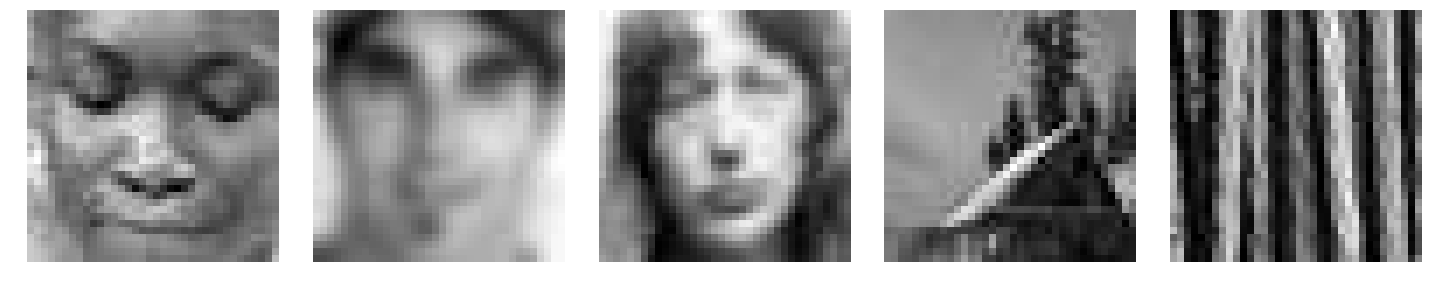

In [62]:
plotImages(sample_training_images[:5])

In [66]:
dropout_rate = 0.3
model = Sequential([
    Conv2D(16, 3, padding='same', activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH ,1)),
    MaxPooling2D(),
    Dropout(dropout_rate),
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Dropout(dropout_rate),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(dropout_rate),
    Dense(1, activation='sigmoid')
])

In [110]:
from sklearn.metrics import roc_auc_score

def auc(y_true, y_pred):
    auc = tf.metrics.AUC(y_true, y_pred)[1]
    K.get_session().run(tf.local_variables_initializer())
    return auc

model.compile(optimizer='adam',
              loss="binary_crossentropy", 
             metrics=["accuracy","AUC"])

In [111]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 36, 36, 16)        160       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 18, 18, 16)        0         
_________________________________________________________________
dropout (Dropout)            (None, 18, 18, 16)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 18, 18, 32)        4640      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 9, 9, 32)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 9, 9, 32)          0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 9, 9, 64)         

In [112]:
epochs = 1
history = model.fit_generator(
    train_data_gen,
    steps_per_epoch=30,
    epochs=epochs,
    validation_data=val_data_gen,
#     validation_steps=len(df) // batch_size
)

30/30 [==============================] - 119s 4s/step - loss: 0.2983 - AUC: 0.9268 - val_loss: 0.3116 - val_AUC: 0.9690


In [113]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

KeyError: 'accuracy'

## Metrics

In [84]:
truth = val_data_gen.labels
prediction = model.predict_generator(val_data_gen)

In [114]:
from sklearn.metrics import roc_auc_score, accuracy_score

print(roc_auc_score(truth, prediction))
print(accuracy_score(truth, np.round(prediction)))

0.48947858316693793
0.6641953772350633


In [131]:
next_batch = next(val_data_gen)
roc_auc_score(next_batch[1], model.predict(next_batch))

0.9828571428571429